In [1]:
import numpy as np
import pandas as pd
import jqdatasdk as jq
import warnings
warnings.filterwarnings("ignore")
from jqdatasdk import opt
jq.auth("15102022205","steven990131")

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


# 查看上证50ETF期权合约

In [2]:
# 通过OPT_CONTRACT_INFO 表获取50etf的所有合约  
df1 = opt.run_query(jq.query(opt.OPT_CONTRACT_INFO).filter(opt.OPT_CONTRACT_INFO.underlying_symbol=='510050.XSHG'))
df1 = df1[['code','trading_code', 'name', 'contract_type','exercise_price','list_date','exercise_date']]
df1.tail()
#df1.to_csv('d:\\Users\\XuranZENG\\Desktop\\50etf.csv')

,code,trading_code,name,contract_type,exercise_price,list_date,exercise_date
2627,10003112.XSHG,510050P2102M04300,50ETF沽2月4300,PO,4.3,2021-01-13,2021-02-24
2628,10003113.XSHG,510050C2103M04300,50ETF购3月4300,CO,4.3,2021-01-13,2021-03-24
2629,10003114.XSHG,510050P2103M04300,50ETF沽3月4300,PO,4.3,2021-01-13,2021-03-24
2630,10003115.XSHG,510050C2106M04300,50ETF购6月4300,CO,4.3,2021-01-13,2021-06-23
2631,10003116.XSHG,510050P2106M04300,50ETF沽6月4300,PO,4.3,2021-01-13,2021-06-23


#  比较期权理论价格和实际价格的差别

本部分以看涨期权定价（10001835.XSHG）为例，运用Garch模型，以60天为时间窗口，滚动计算波动率sigma，并应用BSM模型计算期权理论价格，做理论价格与实际价格的散点图，并进行F检验，检验理论价格和实际价格的总体方差是否相等，即是否存在系统性误差，随后用t检验，检验是否存在非系统性误差。

##   计算理论价格

### 查看期权合约

In [3]:
df2 = opt.run_query(jq.query(opt.OPT_CONTRACT_INFO).filter(opt.OPT_CONTRACT_INFO.code=='10001835.XSHG'))
df2 = df2[['code','trading_code', 'name', 'contract_type','exercise_price','list_date','exercise_date']]
df2

,code,trading_code,name,contract_type,exercise_price,list_date,exercise_date
0,10001835.XSHG,510050C1912A03300,50ETF购12月3247A,CO,3.247,2019-04-25,2019-12-25


### 查看日行情数据

In [4]:
days=(df2.iloc[0]['exercise_date'] - df2.iloc[0]['list_date']).days  
q=jq.query(opt.OPT_DAILY_PRICE).filter(opt.OPT_DAILY_PRICE.code=='10001835.XSHG').order_by(opt.OPT_DAILY_PRICE.date.asc()).limit(days)
df3=opt.run_query(q)
df3.head()

,id,code,exchange_code,date,pre_settle,pre_close,open,high,low,close,change_pct_close,settle_price,change_pct_settle,volume,money,position
0,769477,10001835.XSHG,XSHG,2019-04-25,0.1670,0.1670,0.1558,0.1563,0.1362,0.1400,-16.1677,0.1400,-16.1677,5035.0,7515415.0,1846
1,770947,10001835.XSHG,XSHG,2019-04-26,0.1400,0.1400,0.1388,0.1389,0.1232,0.1235,-11.7857,0.1235,-11.7857,3322.0,4349735.0,2370
2,772419,10001835.XSHG,XSHG,2019-04-29,0.1235,0.1235,0.1210,0.1400,0.1210,0.1275,3.2389,0.1275,3.2389,6454.0,8605825.0,3142
3,773891,10001835.XSHG,XSHG,2019-04-30,0.1275,0.1275,0.1298,0.1340,0.1220,0.1263,-0.9412,0.1263,-0.9412,5406.0,7039429.0,4326
4,775377,10001835.XSHG,XSHG,2019-05-06,0.1263,0.1263,0.1230,0.1230,0.0921,0.1000,-20.8234,0.1000,-20.8234,6282.0,6517246.0,5081


### 设一个滚动的时间窗（过去n天）的价格算出波动率用GARCH模型估计波动率

    GARCH模型是Bollerslev在1986年提出来的，全称为广义自回归条件异方差模型，Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)，是ARCH模型的扩展。GARCH模型认为时间序列每个时间点变量的波动率是最近p个时间点残差平方的线性组合，与最近q个时间点变量波动率的线性组合加起来得到。即GARCH模型的条件方差不仅是滞后残差平方的线性函数，还是滞后条件方差的线性函数，因而GARCH模型适合在计算量不大时，方便地描述高阶的ARCH过程，具有更大的适用性。


In [5]:
n=60

from arch import arch_model
SigmaTable = df3[['date']]
for i in range((n+1),164):     
    pct_change=df3.iloc[(i-n):(i-1)]['close'].pct_change().dropna()
    garch=arch_model(y=pct_change,mean='Constant',lags=0,vol='GARCH',p=1,o=0,q=1,dist='normal')
    garchmodel=garch.fit(update_freq=0)
    sigma=np.sqrt(garchmodel.params[1]/(1-garchmodel.params[2]-garchmodel.params[3]))
    SigmaTable.loc[i,'sigma']=sigma
    
SigmaTable = SigmaTable.dropna()
SigmaTable = SigmaTable.drop(SigmaTable[SigmaTable.loc[:,'sigma'] > 1].index)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -33.12110108704424
            Iterations: 18
            Function evaluations: 100
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -33.038154055822986
            Iterations: 17
            Function evaluations: 93
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -33.73921307406547
            Iterations: 16
            Function evaluations: 88
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -34.96749075484205
            Iterations: 16
            Function evaluations: 90
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -35.39848863347228
            Iterations: 18
            Function e

Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.95105982246004
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -30.00094712728122
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.844311978974968
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -31.347397713410285
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -30.082680060498245
            Iterations: 10
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.32337973485963
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16.03011398311795
            Iterations: 20
            Function evaluations: 119
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16.1620609965823
            Iterations: 17
            Function evaluations: 102
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.594436714557066
            Iterations: 15
            Function evaluations: 87
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.546932533485274
            Iterations: 8
            Function eva

### 计算理论价格

In [6]:
import numpy as np
from math import sqrt, log
from scipy import stats

# 欧式期权BSM定价公式


"""
    Parameters:
    ==========
    S0: float
        标的物初始价格水平
    K: float
       行权价格
    T: float
       到期日
    r: float
       固定无风险短期利率
    sigma: float
       波动因子
    ==========
"""


def N(d):
    value = stats.norm.cdf(d, 0, 1)
    return value

#看涨期权价格
def bsm_call_value(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (np.log(S0 /K) + (r + 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
    d2 = (np.log(S0 /K) + (r - 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
    value = S0 * N(d1) - K * np.exp(-r * T) * N(d2)
    return value

    
#看跌期权价格
def bsm_put_value(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (np.log(S0 /K) + (r + 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
    d2 = (np.log(S0 /K) + (r - 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
    value = bsm_call_value(S0, K, T, r, sigma) - S0 + K * np.exp(-r * T)
    return value

In [7]:
for i in SigmaTable.index:  
    S0=df3.iloc[i]['pre_close']
    #S0=df3.loc[0,'close']
    K=df2.loc[0,'exercise_price']
        
    today = SigmaTable.loc[i,'date']
    exercise_date = df2.iloc[0]['exercise_date']
    T = (exercise_date - today).days
    #T = days
    r=0.026  #SHIBOR=3M利率
    sigma=SigmaTable.loc[i,'sigma']
    price=bsm_call_value(S0, K, T, r, sigma)
    SigmaTable.loc[i,'price']=price
    
df4=df3.loc[:,['date','close']]
Table=pd.merge(SigmaTable, df4, on='date')
Table.tail()

,date,sigma,price,close
62,2019-12-11,0.193449,2.961002e-34,0.0006
63,2019-12-12,0.183366,7.703000e-39,0.0004
64,2019-12-13,0.191166,1.790449e-42,0.0008
65,2019-12-17,0.336984,4.081869e-22,0.0005
66,2019-12-18,0.293151,1.769524e-31,0.0003


##  绘制散点图比较理论价格与实际价格的差异

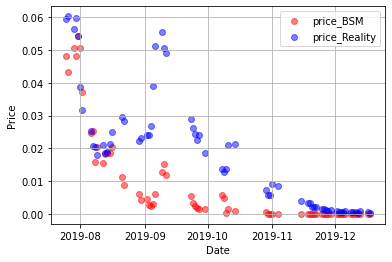

In [8]:
import matplotlib.pyplot as plt

plt.scatter(Table.loc[:,'date'], Table.loc[:,'price'],c="r",alpha=0.5,label="price_BSM")
plt.scatter(Table.loc[:,'date'], Table.loc[:,'close'],c="b",alpha=0.5,label="price_Reality")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc="best")
plt.show()

## 统计检验说明差异来源

### F检验

In [9]:
import numpy as np
import scipy
import scipy.stats as stats

price_BSM = Table.loc[:,'price']
price_Reality = Table.loc[:,'close']



#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

#perform F-test
f_test(price_BSM, price_Reality)


(0.6811539438677691, 0.9393174848987529)

经检验得，F统计量为0.6811539438677691，对应的P值为 0.9393174848987529，因为P值大于0.05,无法拒绝原假设，即理论价格与实际价格符合方差齐次性，不存在系统性误差。

### t检验

In [10]:
import scipy.stats as stats

#perform two sample t-test with equal variances
stats.ttest_ind(price_BSM, price_Reality, equal_var=True)

Ttest_indResult(statistic=-3.3416901950380353, pvalue=0.001083380997745193)

经T检验得，T值为-3.3416901950380353，对应P值为0.001083380997745193。因为P值小于0.05，拒绝原假设，理论价格与实际价格存在显著差异。这可能是由于对历史波动率进行估计时有较大的误差,并且使用BSM所需满足的大多前提假设在现实市场中无法满足，例如市场无摩擦、交易可连续发生等，这些共同导致用BSM模型计算的理论价格与实际价格存在显著差异。

# 计算隐含波动率，做波动率微笑图

## 取同标的同期限不同行权价的若干期权产品

In [11]:
df4 = df1.loc[1750:1758,:]
df4

,code,trading_code,name,contract_type,exercise_price,list_date,exercise_date
1750,10001751.XSHG,510050C1904M02550,50ETF购4月2550,CO,2.55,2019-02-28,2019-04-24
1751,10001752.XSHG,510050C1904M02600,50ETF购4月2600,CO,2.60,2019-02-28,2019-04-24
1752,10001753.XSHG,510050C1904M02650,50ETF购4月2650,CO,2.65,2019-02-28,2019-04-24
1753,10001754.XSHG,510050C1904M02700,50ETF购4月2700,CO,2.70,2019-02-28,2019-04-24
1754,10001755.XSHG,510050C1904M02750,50ETF购4月2750,CO,2.75,2019-02-28,2019-04-24
1755,10001756.XSHG,510050C1904M02800,50ETF购4月2800,CO,2.80,2019-02-28,2019-04-24
1756,10001757.XSHG,510050C1904M02850,50ETF购4月2850,CO,2.85,2019-02-28,2019-04-24
1757,10001758.XSHG,510050C1904M02900,50ETF购4月2900,CO,2.90,2019-02-28,2019-04-24
1758,10001759.XSHG,510050C1904M02950,50ETF购4月2950,CO,2.95,2019-02-28,2019-04-24


## 获取行情数据

In [12]:
from datetime import datetime, date, timedelta
options_list = df4.loc[:,'code'].tolist()

df5=jq.get_price(options_list,end_date='2019-03-06',count=1)
df6 = pd.merge(df4.loc[:,['exercise_price','code']],df5,on='code')

df6

,exercise_price,code,time,open,close,high,low,volume,money
0,2.55,10001751.XSHG,2019-03-06,0.3133,0.3231,0.3380,0.2804,855.0,2650326.0
1,2.60,10001752.XSHG,2019-03-06,0.2697,0.2832,0.2988,0.2452,892.0,2431424.0
2,2.65,10001753.XSHG,2019-03-06,0.2332,0.2462,0.2620,0.2085,1061.0,2527067.0
3,2.70,10001754.XSHG,2019-03-06,0.2052,0.2141,0.2276,0.1799,2524.0,5128366.0
4,2.75,10001755.XSHG,2019-03-06,0.1754,0.1845,0.1970,0.1521,7130.0,12476314.0
5,2.80,10001756.XSHG,2019-03-06,0.1491,0.1580,0.1703,0.1298,13596.0,20493576.0
6,2.85,10001757.XSHG,2019-03-06,0.1235,0.1348,0.1469,0.1103,15457.0,20069024.0
7,2.90,10001758.XSHG,2019-03-06,0.1103,0.1175,0.1268,0.0943,11862.0,13147272.0
8,2.95,10001759.XSHG,2019-03-06,0.0904,0.1008,0.1094,0.0811,11135.0,10723390.0


## 用牛顿迭代法求隐含波动率

In [13]:
#求vega
def bsm_vega(s0,k,t,r,sigma):
    d1 = log( s0/k ) + ( r + 0.5*sigma**2 )*t/( sigma*sqrt(t) )
    vega = s0*stats.norm.cdf(d1,0.,1.)*sqrt(t)
    #print('vega',vega)
    return vega

#牛顿迭代法求隐含波动率，迭代次数设为100
def bsm_call_imp_vol_newton(s0, k, t, r, c0, sigma_est, it = 100):    
    for i in range(it):
        sigma_est -= ((bsm_call_value(s0, k, t, r, sigma_est) - c0)/ 
                      bsm_vega(s0, k, t, r, sigma_est))
    return sigma_est

In [17]:
S0=2.80
r=0.026  #SHIBOR=3M利率
sigma_init=1

#
sigma_newton=[]
K=df6['exercise_price']   
days=(df4.iloc[0]['exercise_date'] - datetime.date(df6.iloc[0]['time'])).days  
T = days/365
price=df6['close'] 
for i in range(df6.shape[0]):
    sigma_newton.append(bsm_call_imp_vol_newton(S0,K[i],T,r,price[i],sigma_init))

    
print('imp_vol_newton:')
print(sigma_newton)



imp_vol_newton:
[0.41512076161919126, 0.3991030310579099, 0.3867968538061807, 0.3821904083172323, 0.37783004028134676, 0.3749527147491976, 0.3739109526510132, 0.3812613438346418, 0.38446220386717006]


## 绘制牛顿法求解的波动率曲线

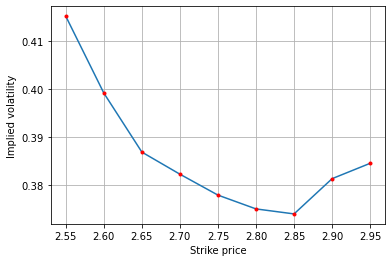

In [15]:
K=df6.loc[:,'exercise_price'] 
plt.plot(K,sigma_newton,lw=1.5)
plt.plot(K,sigma_newton,'r.')
plt.grid(True)
plt.xlabel('Strike price')
plt.ylabel('Implied volatility')
plt.show()

# 参考资料

- 数据来源：https://www.joinquant.com/help/api/help#Option:%E8%8E%B7%E5%8F%96%E6%9C%9F%E6%9D%83%E6%97%A5%E8%A1%8C%E6%83%85%E6%95%B0%E6%8D%AE
- Garch模型：https://blog.csdn.net/hzk427/article/details/105176693
- BSM模型：https://blog.csdn.net/m0_47781094/article/details/108566355
- 隐含波动率： https://github.com/ququcai/volatility_smile/blob/master/volatility_smile.ipynb